# Latent Space and VAEs Demo

This VAE Architecture compresses a 28x28 MNIST digit (784 pixels) into a 2D latent variable $ z = [z_1, z_2] $ using the encoder.

The encoder outputs a mean ($ \mu $) and variance ($ \sigma $) for a Gaussian distribution, and the latent variable is sampled via the reparameterization trick ($ z = \mu + \epsilon \cdot \sigma $, where $ \epsilon \sim \mathcal{N}(0, 1) $).

The decoder reconstructs the image from $ z $ or generates new images by sampling new points in the latent space.

In [2]:
pip install torch

  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.5/212.5 MB 1.1 MB/s eta 0:03:10
   ---------------------------------------- 0.8/212.5 MB 1.2 MB/s eta 0:02:51
   ---------------------------------------- 1.3/212.5 MB 1.4 MB/s eta 0:02:32
   ---------------------------------------- 1.6/212.5 MB 1.4 MB/s eta 0:02:31
   ---------------------------------------- 1.8/212.5 MB 1.4 MB/s eta 0:02:29
   ---------------------------------------- 2.1/212.5 MB 1.5 MB/s eta 0:02:24
   ---------------------------------------- 2.4/212.5 MB 1.5 MB/s eta 0:02:24
    --------------------------------------- 2.9/212.5 MB 1.5 MB/s eta 0:02:20
    --------------------------------------- 3.4/212.5 MB 1.6 MB/s eta 0:02:14
    ------------------

In [4]:
pip install torchvision

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 1.3 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 1.3 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.7 MB 1.4 MB/s eta 0:00:01
   ------------------------------ --------- 1.3/1.7 MB 1.3 MB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:05<00:00, 1.90MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 404kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 1.71MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<?, ?B/s]


Epoch 1, Loss: 184.4591
Epoch 2, Loss: 161.4154
Epoch 3, Loss: 155.6977
Epoch 4, Loss: 152.6980
Epoch 5, Loss: 150.4466


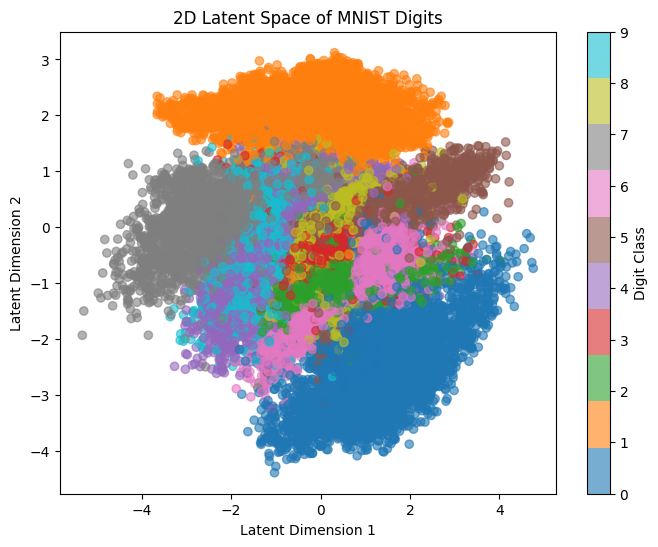

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train_vae(model, data_loader, epochs=5, device='cpu'):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(data_loader.dataset):.4f}')

# Visualization function
def plot_latent_space(model, data_loader, device='cpu'):
    model.eval()
    latent_points = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            latent_points.append(mu.cpu().numpy())
            labels.append(target.numpy())
    latent_points = np.concatenate(latent_points, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('2D Latent Space of MNIST Digits')
    plt.show()

# Main execution
def main():
    # Device
    device = torch.device('cpu')  # Pyodide runs on CPU in browser
    
    # Load MNIST dataset (subset for simplicity)
    transform = transforms.Compose([transforms.ToTensor()])
    try:
        dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    except:
        # Fallback: synthetic data if MNIST download fails in Pyodide
        print("MNIST download unavailable, using synthetic data")
        data = torch.rand(1000, 1, 28, 28)  # Random 28x28 images
        labels = torch.randint(0, 10, (1000,))
        dataset = torch.utils.data.TensorDataset(data, labels)
    
    data_loader = DataLoader(dataset, batch_size=128, shuffle=True)
    
    # Initialize and train VAE
    model = VAE().to(device)
    train_vae(model, data_loader, epochs=5)
    
    # Plot latent space
    plot_latent_space(model, data_loader, device)

if __name__ == "__main__":
    main()

## Latent Space Visualization

The scatter plot shows the 2D latent variables for a batch of MNIST digits, colored by their class (0–9).
 See clusters (e.g., all "1"s grouped together), demonstrating that the latent space organizes similar data points close together.
 Teaching Points

- Latent Variables: Each point in the scatter plot is a latent variable $ z $, capturing the essence of a digit (e.g., its shape or style) in just two numbers.
  
- Latent Space: The 2D plot is the latent space, where each point corresponds to a possible digit. Moving in this space changes the generated digit’s appearance.
   
- Generative Power: By sampling new points (e.g., $ z = [0.5, -0.3] $), the VAE can generate new digits, showing how generative AI creates content

Epoch 1, Loss: 184.5857
Epoch 2, Loss: 161.7982
Epoch 3, Loss: 154.8997
Epoch 4, Loss: 151.3144
Epoch 5, Loss: 148.9069
Epoch 6, Loss: 147.3820
Epoch 7, Loss: 145.8730
Epoch 8, Loss: 144.9830
Epoch 9, Loss: 144.0652
Epoch 10, Loss: 143.5844
Epoch 11, Loss: 142.8047
Epoch 12, Loss: 142.2389
Epoch 13, Loss: 141.8135
Epoch 14, Loss: 141.3935
Epoch 15, Loss: 140.9101


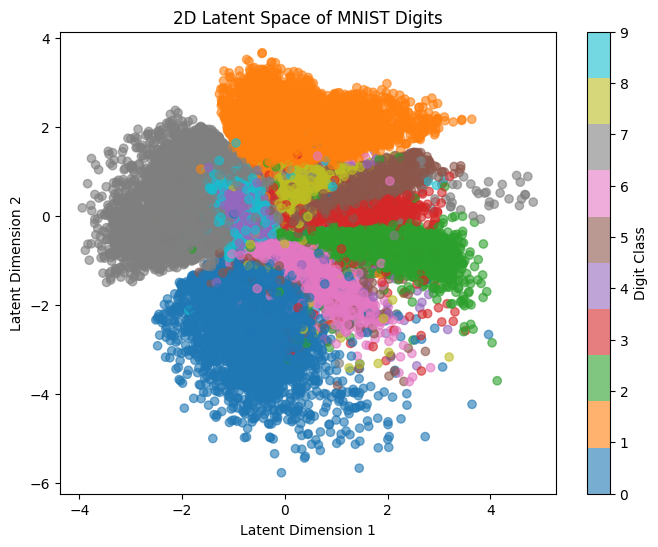

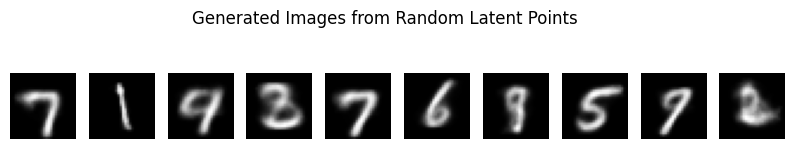

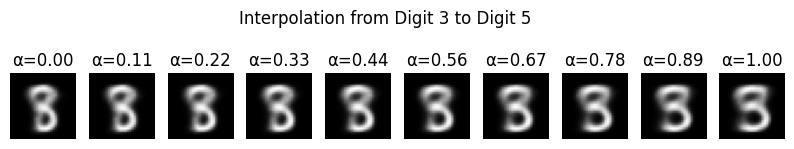

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train_vae(model, data_loader, epochs=10, device='cpu'):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(data_loader.dataset):.4f}')

# Visualize latent space
def plot_latent_space(model, data_loader, device='cpu'):
    model.eval()
    latent_points = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            latent_points.append(mu.cpu().numpy())
            labels.append(target.numpy())
    latent_points = np.concatenate(latent_points, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('2D Latent Space of MNIST Digits')
    plt.show()

# Generate images from random latent variables
def generate_images(model, num_images=10, latent_dim=2, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Sample random points from a standard normal distribution
        z = torch.randn(num_images, latent_dim).to(device)
        generated = model.decode(z).cpu().numpy()
    
    # Plot generated images
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle('Generated Images from Random Latent Points')
    plt.show()

# Interpolate between two digits
def interpolate_images(model, data_loader, digit1=3, digit2=5, steps=10, device='cpu'):
    model.eval()
    # Find one example of each digit
    z1, z2 = None, None
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            for i, label in enumerate(target):
                if label == digit1 and z1 is None:
                    z1 = mu[i:i+1]
                if label == digit2 and z2 is None:
                    z2 = mu[i:i+1]
                if z1 is not None and z2 is not None:
                    break
            if z1 is not None and z2 is not None:
                break
    
    # Linear interpolation between z1 and z2
    alphas = np.linspace(0, 1, steps)
    interpolated_z = torch.zeros(steps, z1.shape[1]).to(device)
    for i, alpha in enumerate(alphas):
        interpolated_z[i] = (1 - alpha) * z1 + alpha * z2
    
    # Generate images from interpolated points
    with torch.no_grad():
        generated = model.decode(interpolated_z).cpu().numpy()
    
    # Plot interpolated images
    plt.figure(figsize=(10, 2))
    for i in range(steps):
        plt.subplot(1, steps, i + 1)
        plt.imshow(generated[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f'α={alphas[i]:.2f}')
    plt.suptitle(f'Interpolation from Digit {digit1} to Digit {digit2}')
    plt.show()

# Main execution
def main():
    # Device
    device = torch.device('cpu')  # runs on CPU
    
    # Load MNIST dataset (subset for simplicity)
    transform = transforms.Compose([transforms.ToTensor()])
    try:
        dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    except:
        # Fallback: synthetic data if MNIST download fails
        print("MNIST download unavailable, using synthetic data")
        data = torch.rand(1000, 1, 28, 28)  # Random 28x28 images
        labels = torch.randint(0, 10, (1000,))
        dataset = torch.utils.data.TensorDataset(data, labels)
    
    data_loader = DataLoader(dataset, batch_size=128, shuffle=True)
    
    # Initialize and train VAE
    model = VAE().to(device)
    train_vae(model, data_loader, epochs=15)
    
    # Plot latent space
    plot_latent_space(model, data_loader, device)
    
    # Generate random images
    generate_images(model, num_images=10, latent_dim=2, device=device)
    
    # Interpolate between digits 3 and 5
    interpolate_images(model, data_loader, digit1=3, digit2=5, steps=10, device=device)

if __name__ == "__main__":
    main()

Epoch 1, Loss: 4.4877
Epoch 2, Loss: 4.4281
Epoch 3, Loss: 4.4225
Epoch 4, Loss: 4.4200
Epoch 5, Loss: 4.4186


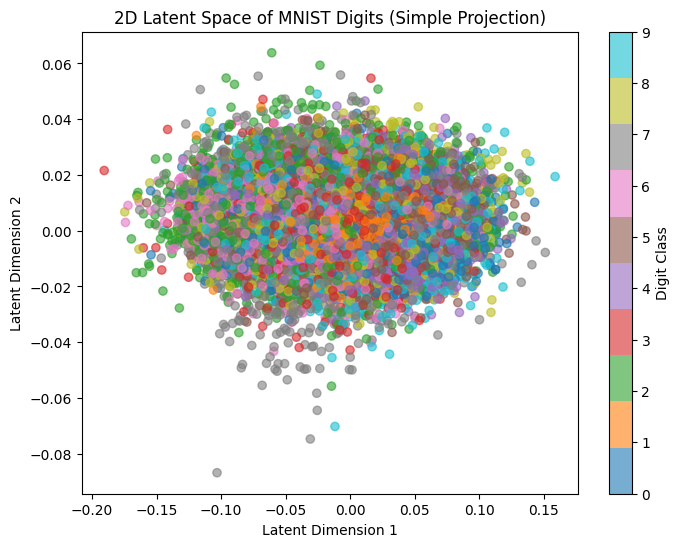

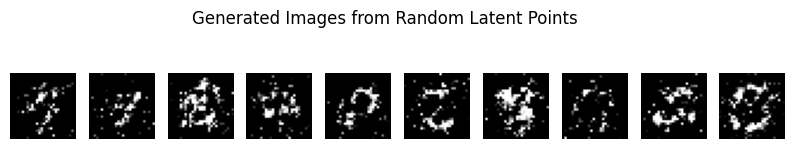

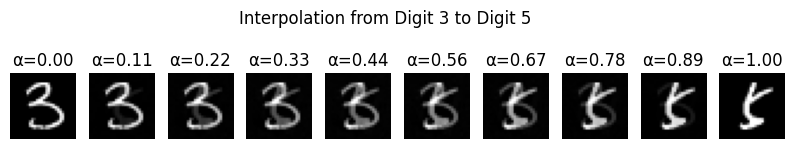

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# RealNVP coupling layer with stabilized scaling
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super(CouplingLayer, self).__init__()
        self.mask = mask
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()  # Bound scale to prevent explosion
        )
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        x_b = x * self.mask
        s = self.scale_net(x_b) * 0.1  # Scale down to stabilize
        t = self.translate_net(x_b)
        y = x_b + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det = torch.sum((1 - self.mask) * s, dim=1)
        return y, log_det

    def inverse(self, y):
        y_b = y * self.mask
        s = self.scale_net(y_b) * 0.1
        t = self.translate_net(y_b)
        x = y_b + (1 - self.mask) * (y - t) * torch.exp(-s)
        return x

# Normalizing Flow model
class RealNVP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, num_layers=4):
        super(RealNVP, self).__init__()
        self.input_dim = input_dim
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            mask = torch.ones(input_dim)
            mask[i % 2::2] = 0  # Checkerboard mask
            self.layers.append(CouplingLayer(input_dim, hidden_dim, mask))
        self.base_dist = torch.distributions.MultivariateNormal(
            torch.zeros(input_dim), torch.eye(input_dim)
        )

    def forward(self, x):
        log_det_sum = 0
        z = x
        for layer in self.layers:
            z, log_det = layer(z)
            log_det_sum += log_det
        return z, log_det_sum

    def inverse(self, z):
        x = z
        for layer in reversed(self.layers):
            x = layer.inverse(x)
        return x

# Loss function with NaN/inf checking
def loss_function(model, x):
    z, log_det = model(x)
    # Check for invalid values
    if torch.isnan(z).any() or torch.isinf(z).any():
        raise ValueError("Invalid values (NaN or inf) in latent variables z")
    log_pz = model.base_dist.log_prob(z)
    if torch.isnan(log_pz).any() or torch.isinf(log_pz).any():
        raise ValueError("Invalid log probability in base distribution")
    return -torch.mean(log_pz + log_det)

# Training function with gradient clipping
def train_flow(model, data_loader, epochs=5, device='cpu'):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=5e-4)  # Lower learning rate
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device).view(-1, 784)
            data = data * 0.5 - 0.5 + torch.randn_like(data) * 0.01  # Normalize and add noise
            optimizer.zero_grad()
            try:
                loss = loss_function(model, data)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
                total_loss += loss.item()
                optimizer.step()
            except ValueError as e:
                print(f"Skipping batch {batch_idx} due to: {e}")
                continue
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(data_loader.dataset):.4f}')

# Visualize latent space (simple projection to first two dimensions)
def plot_latent_space(model, data_loader, device='cpu'):
    model.eval()
    latent_points = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device).view(-1, 784)
            data = data * 0.5 - 0.5  # Normalize
            z, _ = model(data)
            latent_points.append(z.cpu().numpy())
            labels.append(target.numpy())
    latent_points = np.concatenate(latent_points, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    # Project to 2D by selecting first two dimensions
    latent_2d = latent_points[:, :2]  # Use first two dimensions for simplicity
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('2D Latent Space of MNIST Digits (Simple Projection)')
    plt.show()

# Generate images from random latent variables
def generate_images(model, num_images=10, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Sample from base distribution
        z = torch.randn(num_images, model.input_dim).to(device)
        generated = model.inverse(z).cpu().numpy()
        generated = np.clip(generated, -0.5, 0.5)  # Clip to valid range
    
    # Plot generated images
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow((generated[i] + 0.5).reshape(28, 28), cmap='gray')  # Denormalize
        plt.axis('off')
    plt.suptitle('Generated Images from Random Latent Points')
    plt.show()

# Interpolate between two digits
def interpolate_images(model, data_loader, digit1=3, digit2=5, steps=10, device='cpu'):
    model.eval()
    # Find latent representations of digit1 and digit2
    z1, z2 = None, None
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device).view(-1, 784)
            data = data * 0.5 - 0.5  # Normalize
            z, _ = model(data)
            for i, label in enumerate(target):
                if label == digit1 and z1 is None:
                    z1 = z[i:i+1]
                if label == digit2 and z2 is None:
                    z2 = z[i:i+1]
                if z1 is not None and z2 is not None:
                    break
            if z1 is not None and z2 is not None:
                break
    
    # Linear interpolation in latent space
    alphas = np.linspace(0, 1, steps)
    interpolated_z = torch.zeros(steps, z1.shape[1]).to(device)
    for i, alpha in enumerate(alphas):
        interpolated_z[i] = (1 - alpha) * z1 + alpha * z2
    
    # Generate images from interpolated points
    with torch.no_grad():
        generated = model.inverse(interpolated_z).cpu().numpy()
        generated = np.clip(generated, -0.5, 0.5)  # Clip to valid range
    
    # Plot interpolated images
    plt.figure(figsize=(10, 2))
    for i in range(steps):
        plt.subplot(1, steps, i + 1)
        plt.imshow((generated[i] + 0.5).reshape(28, 28), cmap='gray')  # Denormalize
        plt.axis('off')
        plt.title(f'α={alphas[i]:.2f}')
    plt.suptitle(f'Interpolation from Digit {digit1} to Digit {digit2}')
    plt.show()

# Main execution
def main():
    # Device
    device = torch.device('cpu')  # Pyodide runs on CPU in browser
    
    # Load MNIST dataset (subset for simplicity)
    transform = transforms.Compose([transforms.ToTensor()])
    try:
        dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    except:
        # Fallback: synthetic data if MNIST download fails in Pyodide
        print("MNIST download unavailable, using synthetic data")
        data = torch.rand(1000, 1, 28, 28)  # Random 28x28 images
        labels = torch.randint(0, 10, (1000,))
        dataset = torch.utils.data.TensorDataset(data, labels)
    
    data_loader = DataLoader(dataset, batch_size=128, shuffle=True)
    
    # Initialize and train Normalizing Flow
    model = RealNVP(input_dim=784, hidden_dim=400, num_layers=4).to(device)
    train_flow(model, data_loader, epochs=5)
    
    # Plot latent space
    plot_latent_space(model, data_loader, device)
    
    # Generate random images
    generate_images(model, num_images=10, device=device)
    
    # Interpolate between digits 3 and 5
    interpolate_images(model, data_loader, digit1=3, digit2=5, steps=10, device=device)

if __name__ == "__main__":
    main()

### Questions

Answer these questions:

1. Why to plot in 2 dimensions?
2. What happens when epochs increase in model 1 vs 2?
3. Morph between numbers 1 and 7 in any model and comment the results...
4. Which model takes longer to train VAE or Normalizing Flow?
5. Which model got better results?
6. Why the Normalizing Flow Model got a smaller Loss?
   